Data-Driven Neural Networks for Windkessel Parameter Calibration
Notebook
==============

<img src="graphical_abstract.png" width="50%" alt="NN Calibration">


***Simulating Blood Flow***

Understanding and influencing the local ***blood flow*** are key stones in many medical applications, such as patient-specific heat therapy or monitoring the effect of motion therapy. Simulation models allow us to approximate the blood flow at different parts of the human body, provided they are calibrated to actual measurements of the patient. In our recent work ([Hoock, Koeppl 2025](https://doi.org/10.48550/arXiv.2509.21206)), we propose a method to accelerate this calibration procedure. Instead of the time-consuming process of tuning the complex mathematical model step-by-step, we ***replace*** the relevant part with a much faster neural network (NN) surrogate. The NN is trained to accurately reproduce the complex model's prediction at the left brachial artery, which is relevant for the calibration. That way, the calibration results are almost identical, but identified much faster.


***Calibration of Model Parameters***

This notebook interactively demonstrates the main features of our method. Based on a time-resolved measurement of the **blood pressure** at the left upper arm, our approach accurately **calibrates** the main model parameters of the actual simulation model: the so-called Windkessel parameters. These parameters are part of a dimensionally reduced 1D-0D coupled model of the arterial network. This model essentially describes the larger arteries as one-dimensional tubes and the average effect of the smaller arteries as electrical circuits. Our main interest is to find the ***global Windkessel parameters*** — the overall resistance and compliance (also called capacitance) — of this model. Calibrating these parameters to best fit a patient's measurement allows the simulation to better reflect the actual conditions within the patient.


***Neural Network Surrogate***

This calibration is based on a **neural network** that has been trained on reference data from the 1D-OD model to serve as a fast and accurate surrogate during calibration. The neural network is trained specifically for the blood pressure at the left upper arm, where measurement devices are usually placed. The code below emulates such a time-resolved measurement of the blood pressure using synthetic data with optionally added noise to model measurement error. The pretrained neural network is then retrained, thereby adapting the calibration variables to best reproduce the proxy measurement. This procedure is performed on the fly and directly yields the optimally calibrated Windkessel parameters, i.e. the global resistance $R$ and compliance $C$.


***Correction of Misalignment in Space and Time***

Our calibration also accounts for two problems in real-world measurement setups:
- ***Unknown position***: The exact location $z$ of the measurement device on the artery might be unknown. Since assuming an incorrect position would change the blood pressure prediction and thus also distort the calibration, the neural network internally finds the best-matching position.
- ***Asynchronous phases***: The measurement and the prediction of the neural network could be asynchronous in time. This is also corrected internally by the neural network, which shifts its prediction by the best-suited phase lag $\tau$.
All of these optimization steps are handled jointly and entirely within the neural network. The notebook demonstrates these main functionalities of our calibration approach.

<br>

**How It Works:**
- Simply click the buttons to proceed through the parts.
- ***First, generate a measurement.*** You can select:
  - Between two default sample "patients" or a random person.
  - Whether the position is known (if known, you can select the position; otherwise, a random position is assumed).
  - Whether the measurement starts with the diastolic pressure (if so, it has a phase close to that of the NN, if not, the signal is shifted randomly).
  - If the measurement is noisy (if so, you can select the noise characteristics).
- ***Next, display the measurement.***
- ***To run the calibration, choose:***
  - If the used NN surrogate was trained on a large or a small simulated data set (alternatively, you can type one of the other models).
  - If the calibration is verbose or not.
  - If you want additional plots shown during calibration.
  - If the calibration should stop early (if the optimization does not change significantly after some time).
- ***Then start the calibration.***
- After a few seconds, you will see the optimal Windkessel parameters and optionally the optimal position in a pop-up window. You also see the percentage error and the true parameters for comparison.
- Lastly, you can display the blood pressure curve predicted by the neural network with the optimal parameters. This allows checking the agreement with the measurement.

The notebook can be re-run easily with changed options. Possibly, you may have to re-run some cells.

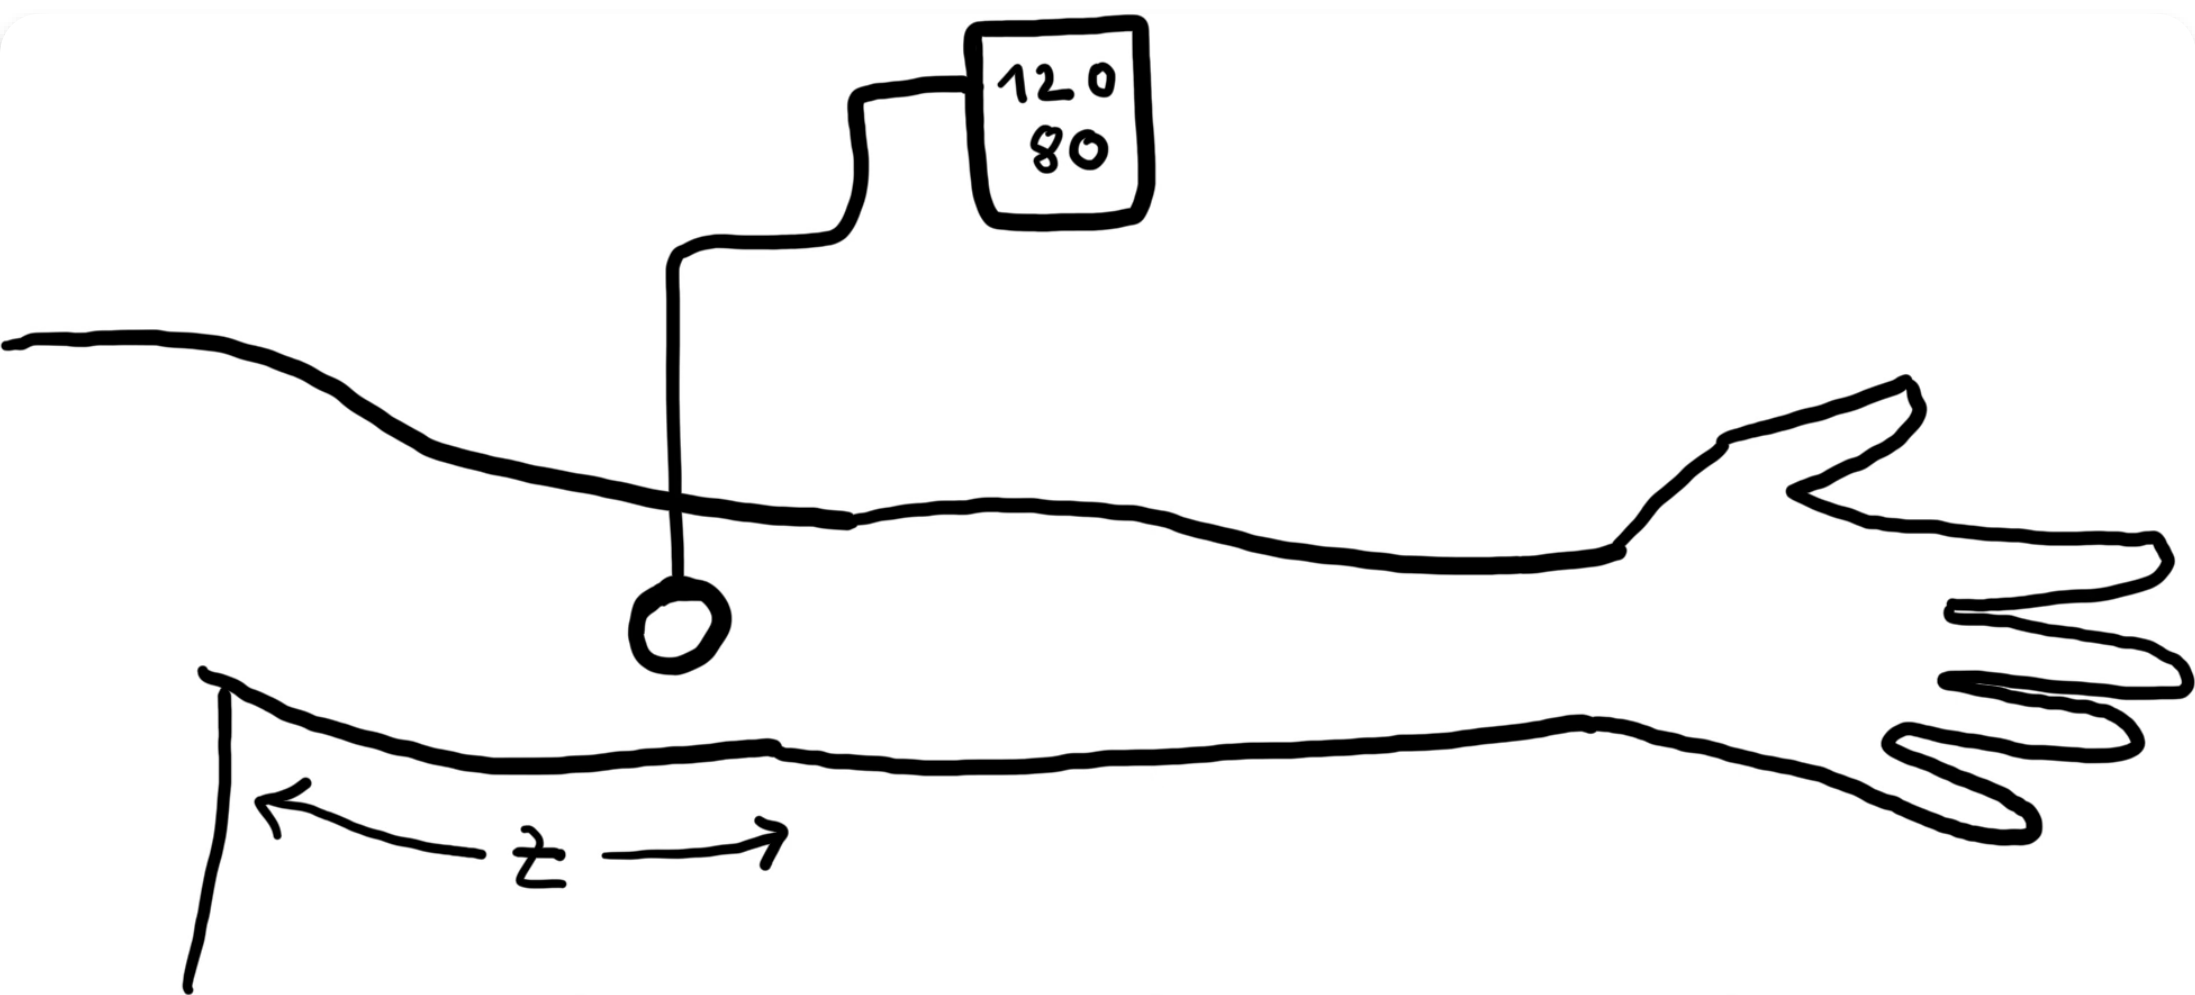

In [46]:
with open('for_notebook.py') as fl:
    exec(fl.read())    
#%matplotlib inline

im = Image(filename = "upper_arm.png",width=439,height=199)
display(im)


Mn_dd = widgets.Dropdown(
    options=[('patient 1', 1), ('patient 2', 2), ('random', -1)],
    value=-1,
    description='Target Case:',
    layout=widgets.Layout(width='200px')
)

z_dd = widgets.Dropdown(
    options=['position known', 'position unknown'],
    value='position known',
    description='',
    layout=widgets.Layout(width='200px')
)

slider_z = widgets.FloatSlider(
    value=set_z[15]*100,
    min=set_z[0]*100.,
    max=set_z[-1]*100.,
    step=(set_z[1]-set_z[0])*100.,
    description='Position $z$ [cm]',
    readout_format='.1f',
    layout=Layout(width='500px',margin='10px 0 0 0'),
    style={'description_width': '200px'}
)

# Container to hide/show the slider
custom_z_box = widgets.VBox([slider_z])
custom_z_box.layout.display = 'block'  # Start visible

# Function to update the visibility of the slider
def on_z_change(change):
    if change['new'] == 'position unknown':
        custom_z_box.layout.display = 'none'  # Hide it
    if change['new'] == 'position known':
        custom_z_box.layout.display = 'block'  # Show it

# Attach the update function to the checkbox
z_dd.observe(on_z_change, names='value')


phase_check = widgets.Checkbox(
    value=False,
    description='Random Phase',
    disabled=False,
    indent=False,
    layout=widgets.Layout(width='200px', flex='0 0 auto')
)

noise_check = widgets.Checkbox(
    value=False,
    description='Add Noise:',
    indent=False,
    layout=widgets.Layout(width='200px', flex='0 0 auto')
)

slider_mu = widgets.IntSlider(
    value=0,
    min=-2,
    max=2,
    step=1,
    description='$\mu$ [mmHg] (Bias):',
    layout=Layout(width='500px'),
    style={'description_width': '200px'}
)

slider_sigma = widgets.IntSlider(
    value=2,
    min=0,
    max=5,
    step=1,
    description='$\sigma$ [mmHg] (Variance):',
    layout=Layout(width='500px'),
    style={'description_width': '200px'}
)


# Container to hide/show the sliders
custom_noise_box = widgets.VBox([slider_mu,slider_sigma])
custom_noise_box.layout.display = 'none'  # Start hidden

# Function to handle dropdown changes
def on_noise_change(change):
    if change['new']:
        custom_noise_box.layout.display = 'block'  # Show it
    else:
        custom_noise_box.layout.display = 'none'  # Hide it

# Attach the observer
noise_check.observe(on_noise_change, names='value')


# set up and show
run_bt = widgets.Button(description="Make Measurement")
output = widgets.Output()

run_bt.on_click(set_up_and_show)

layout = widgets.VBox([
    widgets.HBox([], layout=widgets.Layout(height='20px')),
    widgets.HBox([Mn_dd], layout=widgets.Layout(min_height='40px')),
    widgets.VBox([z_dd,custom_z_box], layout=widgets.Layout(min_height='40px')),
    widgets.HBox([], layout=widgets.Layout(height='10px')),
    widgets.HBox([phase_check], layout=widgets.Layout(min_height='40px')),
    widgets.HBox([noise_check]),
    widgets.HBox([], layout=widgets.Layout(height='5px')),
    widgets.HBox([custom_noise_box]),
    widgets.HBox([], layout=widgets.Layout(height='20px')),
    run_bt,
    output
])

display(layout)

In [47]:
# Dropdown with new option
model_dd = widgets.Dropdown(
    options=[
        ('all data', "0"),('reduced mesh', "G"),('specify other', 'other')],
    value="0",
    description='Choose NN Model:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='250px')
)

# Text input (initially hidden)
custom_model_input = widgets.Text(
    description='Type Model Code:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='230px'),
    placeholder='e.g. RC3',
    visible=False  # Initially hidden
)

# Static help text
available_options_text = widgets.HTML(
    value=string_model_options,
    layout=widgets.Layout(padding='5px 0px 0px 5px')
)

# Container to hide/show the text box
custom_input_box = widgets.VBox([custom_model_input,available_options_text])
custom_input_box.layout.display = 'none'  # Start hidden

# Function to handle dropdown changes
def on_model_change(change):
    if change['new'] == 'other':
        custom_input_box.layout.display = ''  # Show it
    else:
        custom_input_box.layout.display = 'none'  # Hide it

# Attach the observer
model_dd.observe(on_model_change, names='value')

es_check = widgets.Checkbox(
    value=False,
    description='Early Stopping',
    disabled=False,
    indent=False
)

verbose_check = widgets.Checkbox(
    value=False,
    description='Verbose',
    disabled=False,
    indent=False
)

plots_check = widgets.Checkbox(
    value=False,
    description='Make Plots',
    disabled=False,
    indent=False
)

run_bt = widgets.Button(description="Start Calibration")
output = widgets.Output()

run_bt.on_click(calibrate)

# Display the button
VBox(children=[model_dd,custom_input_box,es_check,verbose_check,plots_check,run_bt,output])

In [45]:
run_bt = widgets.Button(description="Show NN Prediction")
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        run_bt.on_click(plot_ref_pred(b,label_nn='NN',no_NN=False,small=False,title='after calibration'))

#run_bt.on_click(plot_after_cal)
run_bt.on_click(on_button_click)

# Display the button
display(run_bt,output)

Button(description='Show NN Prediction', style=ButtonStyle())

Output()

***AI policy:*** the text and code of this notebook has been generated under assistance of AI. The developers supervised the final version.